## Bayesian Optimization

Bayesian Optimization uses a Gaussian Process (GP) to construct a posterior distribution that describes the function
you want to optimize. As the number of observations increases, the algorithm becomes more certain of which regions in the parameter space are worth exploring and which are not, thus balancing exploration vs exploitation trade-off. Here we use Bayesian Optimization for hyper-parameter tuning for an SVM and a Random Forest Classifier.

In [34]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization

Load dataset and target values:

In [26]:
np.random.seed(0)

# Load data set and target values
data, target = make_classification(
    n_samples=1000,
    n_features=45,
    n_informative=12,
    n_redundant=7
)

target = target.ravel()

Define cross-validation score functions to be used by Bayesian Optimizer:

In [30]:
def svccv(gamma):
    val = cross_val_score(
        SVC(gamma=gamma, random_state=0),
        data, target, scoring='f1', cv=2
    ).mean()

    return val

def rfccv(n_estimators, max_depth):
    val = cross_val_score(
        RFC(n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            random_state=0
        ),
        data, target, scoring='f1', cv=2
    ).mean()
    
    return val

Define plot utilities for visualizing GP mean and covariance functions as well as the acquisition function.

In [31]:
def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((0, 0.1))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((0, 0.1))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend()
    acq.legend()

Use Bayesian Optimization to find hyperparmeters that maximize the cross-validation score:

In [32]:
gp_params = {"alpha": 1e-5}

#SVM
svcBO = BayesianOptimization(svccv,
    {'gamma': (0.00001, 0.1)})

svcBO.maximize(init_points=3, n_iter=4, **gp_params)

#Random Forest
rfcBO = BayesianOptimization(
    rfccv,
    {'n_estimators': (10, 300),
     'max_depth': (2, 10)
    }
)
rfcBO.explore({'max_depth': [2, 4, 6], 'n_estimators': [64, 128, 256]})

rfcBO.maximize(init_points=4, n_iter=4, **gp_params)

print('Final Results')
print('SVC: %f' % svcBO.res['max']['max_val'])
print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-----------------------------------------
 Step |   Time |      Value |     gamma | 
    1 | 00m00s |    0.69882 |    0.0655 | 
    2 | 00m00s |    0.81587 |    0.0446 | 
    3 | 00m00s |    0.83479 |    0.0323 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |     gamma | 


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    4 | 00m01s |    0.00000 |    0.0000 | 
    5 | 00m01s |    0.03550 |    0.1000 | 
    6 | 00m01s |    0.82342 |    0.0543 | 
    7 | 00m02s |    0.82689 |    0.0375 | 
Initialization
------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   n_estimators | 
    1 | 00m00s |    0.71025 |      2.0000 |        64.0000 | 
    2 | 00m01s |    0.73474 |      4.0000 |       128.0000 | 
    3 | 00m02s |    0.74213 |      6.0000 |       256.0000 | 
    4 | 00m02s |    0.69599 |      2.1959 |       275.2334 | 
    5 | 00m01s |    0.75242 |      8.7515 |       145.5433 | 
    6 | 00m01s |    0.77184 |      9.8781 |       157.2206 | 
    7 | 00m02s |    0.76795 |      7.8932 |       216.1075 | 
Bayesian Optimization
------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   n_estimators | 
    8 | 00m09s |    0.70787 |      9.9391 |        10.0717 | 


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.16757870e-05]), 'nit': 3, 'funcalls': 48}
  " state: %s" % convergence_dict)


    9 | 00m07s |    0.69723 |      2.0028 |       181.7024 | 
   10 | 00m06s |    0.76978 |      9.9953 |        96.6640 | 
   11 | 00m10s |    0.76292 |     10.0000 |       300.0000 | 
Final Results
SVC: 0.834794
RFC: 0.771837


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00045111]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)


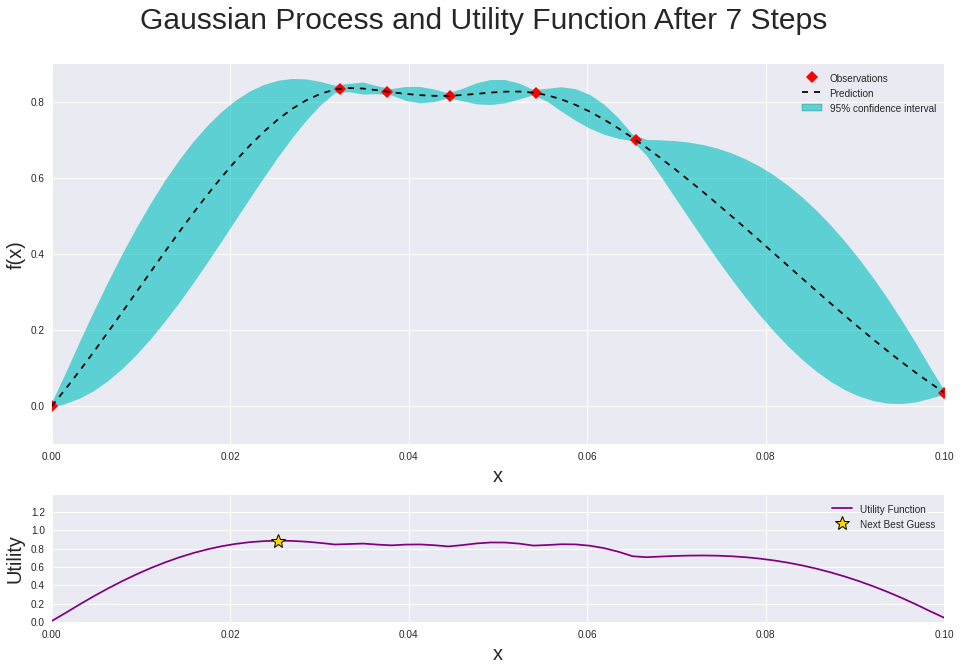

In [35]:
#visualize results
x = np.linspace(0.00001,0.1,64).reshape(-1,1)
plot_gp(svcBO,x)
plt.show()

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


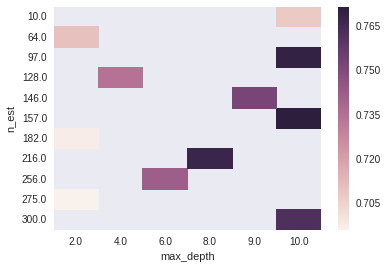

In [36]:
rfc_X = map(lambda x: round(x,0), rfcBO.X[:,0])
rfc_Y = map(lambda x: round(x,0), rfcBO.X[:,1])
data = pd.DataFrame(data={'n_est':rfc_X,'max_depth':rfc_Y,'score':rfcBO.Y})
data = data.pivot(index='n_est', columns='max_depth', values='score')
sns.heatmap(data)
plt.show()

In [40]:
print svcBO.res['max']['max_params']
print rfcBO.res['max']['max_params']

{'gamma': 0.032338638360763713}
{'n_estimators': 157.22056986868373, 'max_depth': 9.8781078221842318}


The figure above shows Bayesian Optimization of F1 score as a function of gamma parameter for SVM RBF kernel. We can see that after 7 iterations, we have discovered the gamma parameter that gives the maximum F1 score. The peak of the utility function tells us which experiment to perform next. Similarly, we found that 127 trees of depth 10 achieve the maximum F1 score for the random forest classifier on the synthetic dataset.